In [1]:
import tensorflow as tf
import numpy as numpy
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Normalization, Dense, InputLayer, Conv2D,MaxPool2D,Flatten,BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


## Data Prep

In [2]:
dataset,dataset_info=tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

In [3]:
def splits(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):

    DATASET_SIZE=len(dataset)
    train_dataset=dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
    val_test_dataset=dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset=val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset=val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset,val_dataset,test_dataset

In [4]:
for data in dataset[0].take(4):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(115, 157, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [5]:
TRAIN_RATIO=0.8
VAL_RATIO=0.1
TEST_RATIO=0.1
train_dataset, val_dataset, test_dataset = splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]


In [6]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\nagra\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin 

## Data Visualization

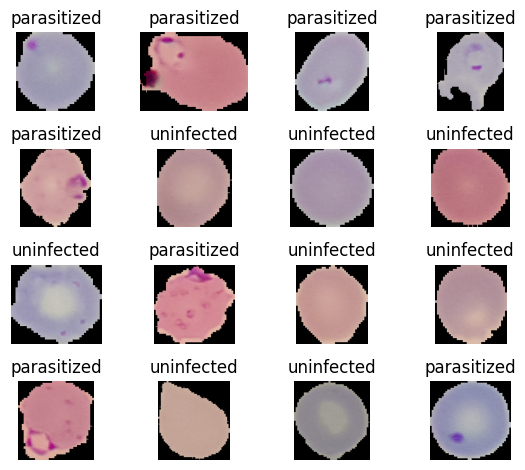

In [7]:
for i, (image,label) in enumerate(train_dataset.take(16)):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')
    plt.tight_layout()

In [8]:
dataset_info.features['label'].int2str(0)

'parasitized'

## Data Pre-Processing

In [9]:
# Standardize or Normalize the images? Read how o decide! 

In [10]:
IMSIZE=224
def resize_rescale(image,label):
    return tf.image.resize(image,(IMSIZE,IMSIZE))/255.0, label

In [11]:
train_dataset=train_dataset.map(resize_rescale)
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)

In [12]:
for image,label in train_dataset.take(1):
    print(image)
    print(label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


In [13]:
train_dataset=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
val_dataset=val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

## Sequential Model

In [46]:
#LeNet
model=tf.keras.Sequential([InputLayer(input_shape=(IMSIZE,IMSIZE,3)),
                           Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu'),
                           BatchNormalization(),
                           MaxPool2D(pool_size=2,strides=2),

                           Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu'),
                           BatchNormalization(),

                           MaxPool2D(pool_size=2,strides=2),

                           Flatten(),

                           Dense(100,activation="relu"),
                           BatchNormalization(),
                           Dense(10,activation="relu"),
                           BatchNormalization(),
                           Dense(1,activation="sigmoid"),

                           
                           ])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

## Functional API

In [22]:
func_input = Input(shape=(IMSIZE,IMSIZE,3), name='Input Image')
x=Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu')(func_input)
x=BatchNormalization()(x)
x=MaxPool2D(pool_size=2,strides=2)(x)

x=Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu')(x)
x=BatchNormalization()(x)
output=MaxPool2D(pool_size=2,strides=2)(x)
lenet_model_extrator=Model(inputs=func_input,outputs=output,name='LeNet_Extractor')
lenet_model_extrator.summary()

Model: "LeNet_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Batc  (None, 109, 109, 16) 

In [23]:
func_input = Input(shape=(IMSIZE,IMSIZE,3), name='Input Image')
x=lenet_model_extrator(func_input)
x=Flatten()(x)
x=Dense(100,activation="relu")(x)
x=BatchNormalization()(x)
x=Dense(10,activation="relu")(x)
x=BatchNormalization()(x)
func_output=Dense(1,activation="sigmoid")(x)
model=Model(inputs=func_input, outputs=func_output, name='LeNet')
model.summary()

Model: "LeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 LeNet_Extractor (Functional  (None, 54, 54, 16)       1136      
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_8 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                1010  

## Model Training

In [18]:
#Binary Croos ENtropy Loss
y_true=[0,1,0,0]
y_pred=[0.6,0.51,0.94,1]
bce=tf.keras.losses.BinaryCrossentropy()
bce(y_true,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [19]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics='accuracy'
            )

In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9453484357262605913
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3399626249651885229
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [21]:
history=model.fit(train_dataset,validation_data=val_dataset,epochs=20,verbose=1)

Epoch 1/20


689/689 [==============================] - 60s 70ms/step - loss: 0.2996 - accuracy: 0.8787 - val_loss: 0.2657 - val_accuracy: 0.9082
Epoch 2/20
 19/689 [..............................] - ETA: 42s - loss: 0.2033 - accuracy: 0.9309

KeyboardInterrupt: 

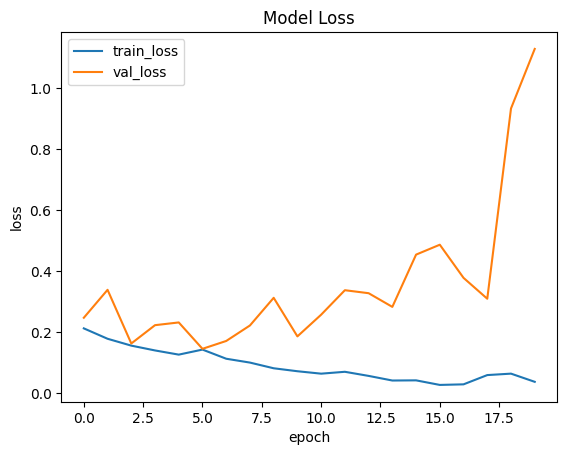

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

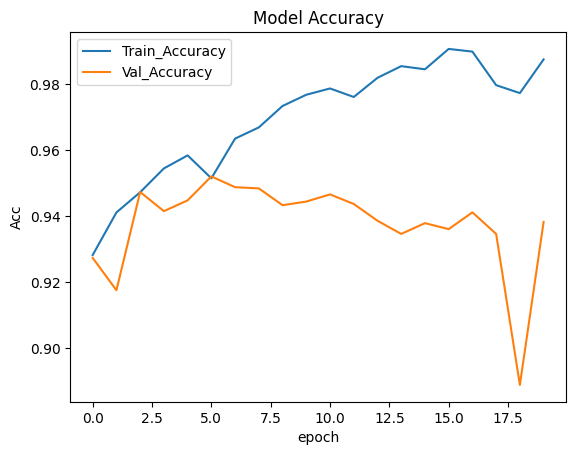

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['Train_Accuracy','Val_Accuracy'])
plt.show()

## Model Eval and Testing

In [61]:
test_dataset=test_dataset.batch(1)

In [62]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 15s 5ms/step - loss: 1.0095 - accuracy: 0.9373


[1.0094751119613647, 0.9372506141662598]

In [63]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 3s 3s/step


0.98733157

In [64]:
def parasite_or_not(x):
    if(x<0.5):
        return str('P')
    else:
        return str('U')

In [66]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 3s 3s/step


'U'

1/1 [==============================] - 0s 27ms/step


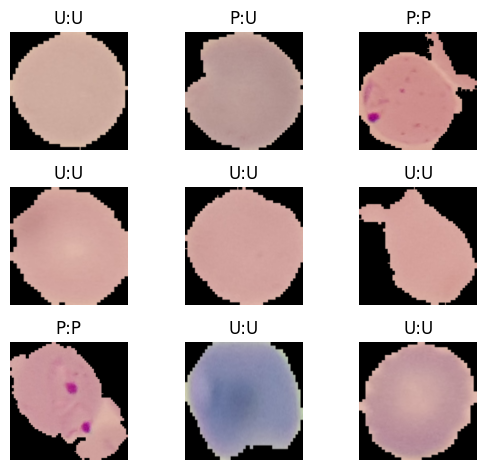

In [68]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0]))+":"+str(parasite_or_not(model.predict(image)[0][0])))
    plt.axis('off')
    plt.tight_layout()